In [3]:
import numpy as np

# Определение целевой функции
def objective_function(x):
    return 0.5 * (x[0]**2 + (x[0] - x[1])**2 + (x[1] - x[2])**2 + x[2]**2) - x[0]

# Пример точки, для которой будем считать значение функции
x0 = np.array([1.0, 1.0, 1.0])
print(f"f(x0) = {objective_function(x0)}")


f(x0) = 0.0


In [4]:
# Аналитический градиент функции
def gradient(x):
    grad = np.zeros_like(x)
    grad[0] = x[0] + 2 * (x[0] - x[1]) - 1
    grad[1] = 2 * (x[1] - x[0]) + 2 * (x[1] - x[2])
    grad[2] = 2 * (x[2] - x[1]) + x[2]
    return grad

print(f"Градиент f(x0) = {gradient(x0)}")


Градиент f(x0) = [0. 0. 1.]


In [5]:
# Метод конечных разностей (вперед)
def finite_difference_gradient_forward(x, h=1e-5):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_h = np.copy(x)
        x_h[i] += h
        grad[i] = (objective_function(x_h) - objective_function(x)) / h
    return grad

print(f"Численный градиент (вперед) f(x0) = {finite_difference_gradient_forward(x0)}")


Численный градиент (вперед) f(x0) = [1.00000008e-05 1.00000008e-05 1.00001000e+00]


In [6]:
# Алгоритм BFGS
def BFGS(x0, gradient_func, max_iter=100, tol=1e-6):
    x = x0
    H = np.eye(len(x))  # Инициализация единичной матрицей Гессе
    for i in range(max_iter):
        grad = gradient_func(x)
        if np.linalg.norm(grad) < tol:
            break  # Условие останова
        p = -H @ grad  # Направление шага
        alpha = 1.0  # Можно улучшить с помощью линейного поиска
        x_new = x + alpha * p
        grad_new = gradient_func(x_new)
        
        # Обновление матрицы Гессе по методу BFGS
        s = x_new - x
        y = grad_new - grad
        rho = 1.0 / (y.T @ s)
        I = np.eye(len(x))
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
        
        x = x_new
    return x

x_opt = BFGS(x0, gradient)
print(f"Оптимальное значение x = {x_opt}")
print(f"f(x_opt) = {objective_function(x_opt)}")


Оптимальное значение x = [0.66666668 0.50000011 0.33333332]
f(x_opt) = -0.36111111578122584


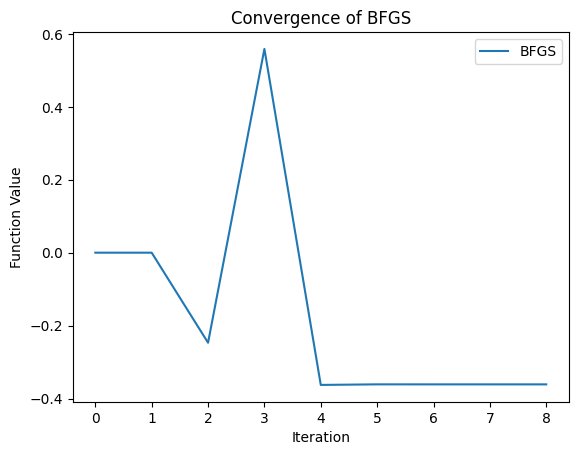

In [7]:
import matplotlib.pyplot as plt

# Модифицированный BFGS для сохранения значений функции на каждой итерации
def BFGS_with_tracking(x0, gradient_func, max_iter=100, tol=1e-6):
    x = x0
    H = np.eye(len(x))
    function_values = [objective_function(x0)]  # Сохраняем значения функции
    for i in range(max_iter):
        grad = gradient_func(x)
        if np.linalg.norm(grad) < tol:
            break
        p = -H @ grad
        alpha = 1.0
        x_new = x + alpha * p
        grad_new = gradient_func(x_new)
        
        s = x_new - x
        y = grad_new - grad
        rho = 1.0 / (y.T @ s)
        I = np.eye(len(x))
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
        
        x = x_new
        function_values.append(objective_function(x))
    
    return x, function_values

# Оптимизация с отслеживанием
x_opt, function_values = BFGS_with_tracking(x0, gradient)

# Визуализация сходимости
plt.plot(function_values, label="BFGS")
plt.xlabel("Iteration")
plt.ylabel("Function Value")
plt.title("Convergence of BFGS")
plt.legend()
plt.show()


In [8]:
# Алгоритм L-BFGS
def L_BFGS(x0, gradient_func, m=10, max_iter=100, tol=1e-6):
    x = x0
    s_list, y_list = [], []  # Списки для хранения последних m шагов
    for i in range(max_iter):
        grad = gradient_func(x)
        if np.linalg.norm(grad) < tol:
            break
        if len(s_list) > m:
            s_list.pop(0)
            y_list.pop(0)
        
        q = grad
        alpha_list = []
        for s, y in zip(reversed(s_list), reversed(y_list)):
            rho = 1.0 / (y.T @ s)
            alpha = rho * (s.T @ q)
            alpha_list.append(alpha)
            q = q - alpha * y
        
        H_0 = np.eye(len(x))
        z = H_0 @ q
        for s, y, alpha in zip(s_list, y_list, reversed(alpha_list)):
            rho = 1.0 / (y.T @ s)
            beta = rho * (y.T @ z)
            z = z + s * (alpha - beta)
        
        p = -z
        alpha = 1.0
        x_new = x + alpha * p
        grad_new = gradient_func(x_new)
        
        s_list.append(x_new - x)
        y_list.append(grad_new - grad)
        
        x = x_new
    return x

x_opt_LBFGS = L_BFGS(x0, gradient)
print(f"Оптимальное значение x (L-BFGS) = {x_opt_LBFGS}")


Оптимальное значение x (L-BFGS) = [0.66666668 0.50000011 0.33333332]


In [10]:
# Модифицированный L-BFGS для сохранения значений функции на каждой итерации
def L_BFGS_with_tracking(x0, gradient_func, m=10, max_iter=100, tol=1e-6):
    x = x0
    s_list, y_list = [], []  # Списки для хранения последних m шагов
    function_values = [objective_function(x0)]  # Сохраняем значения функции
    
    for i in range(max_iter):
        grad = gradient_func(x)
        if np.linalg.norm(grad) < tol:
            break
        if len(s_list) > m:
            s_list.pop(0)
            y_list.pop(0)
        
        q = grad
        alpha_list = []
        for s, y in zip(reversed(s_list), reversed(y_list)):
            rho = 1.0 / (y.T @ s)
            alpha = rho * (s.T @ q)
            alpha_list.append(alpha)
            q = q - alpha * y
        
        H_0 = np.eye(len(x))
        z = H_0 @ q
        for s, y, alpha in zip(s_list, y_list, reversed(alpha_list)):
            rho = 1.0 / (y.T @ s)
            beta = rho * (y.T @ z)
            z = z + s * (alpha - beta)
        
        p = -z
        alpha = 1.0  # Можно улучшить с линейным поиском
        x_new = x + alpha * p
        grad_new = gradient_func(x_new)
        
        s_list.append(x_new - x)
        y_list.append(grad_new - grad)
        
        x = x_new
        function_values.append(objective_function(x))  # Добавляем значение функции
    
    return x, function_values


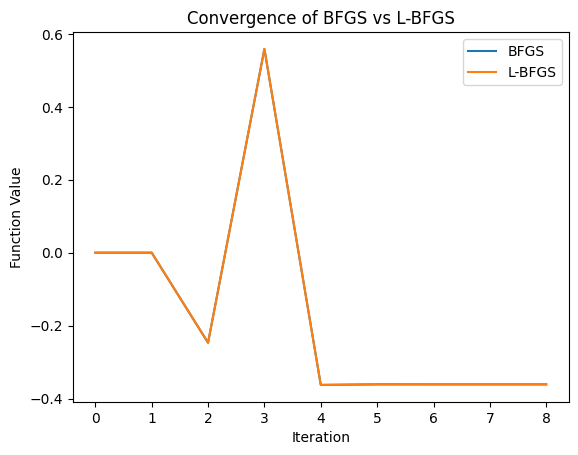

In [11]:
# Оптимизация с отслеживанием для BFGS и L-BFGS
x_opt_BFGS, values_BFGS = BFGS_with_tracking(x0, gradient)
x_opt_LBFGS, values_LBFGS = L_BFGS_with_tracking(x0, gradient)

# Визуализация сходимости BFGS и L-BFGS
plt.plot(values_BFGS, label="BFGS")
plt.plot(values_LBFGS, label="L-BFGS")
plt.xlabel("Iteration")
plt.ylabel("Function Value")
plt.title("Convergence of BFGS vs L-BFGS")
plt.legend()
plt.show()



In [12]:
# Модифицированный BFGS для отслеживания нормы градиента
def BFGS_with_gradient_tracking(x0, gradient_func, max_iter=100, tol=1e-6):
    x = x0
    H = np.eye(len(x))  # Инициализация единичной матрицей Гессе
    function_values = [objective_function(x0)]  # Сохраняем значения функции
    gradient_norms = [np.linalg.norm(gradient_func(x0))]  # Сохраняем нормы градиента
    
    for i in range(max_iter):
        grad = gradient_func(x)
        if np.linalg.norm(grad) < tol:
            break
        p = -H @ grad  # Направление шага
        alpha = 1.0  # Можно улучшить с помощью линейного поиска
        x_new = x + alpha * p
        grad_new = gradient_func(x_new)
        
        # Обновление матрицы Гессе по методу BFGS
        s = x_new - x
        y = grad_new - grad
        rho = 1.0 / (y.T @ s)
        I = np.eye(len(x))
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
        
        x = x_new
        function_values.append(objective_function(x))
        gradient_norms.append(np.linalg.norm(grad_new))  # Добавляем норму градиента
    
    return x, function_values, gradient_norms

# Модифицированный L-BFGS для отслеживания нормы градиента
def L_BFGS_with_gradient_tracking(x0, gradient_func, m=10, max_iter=100, tol=1e-6):
    x = x0
    s_list, y_list = [] , []  # Списки для хранения последних m шагов
    function_values = [objective_function(x0)]  # Сохраняем значения функции
    gradient_norms = [np.linalg.norm(gradient_func(x0))]  # Сохраняем нормы градиента
    
    for i in range(max_iter):
        grad = gradient_func(x)
        if np.linalg.norm(grad) < tol:
            break
        if len(s_list) > m:
            s_list.pop(0)
            y_list.pop(0)
        
        q = grad
        alpha_list = []
        for s, y in zip(reversed(s_list), reversed(y_list)):
            rho = 1.0 / (y.T @ s)
            alpha = rho * (s.T @ q)
            alpha_list.append(alpha)
            q = q - alpha * y
        
        H_0 = np.eye(len(x))
        z = H_0 @ q
        for s, y, alpha in zip(s_list, y_list, reversed(alpha_list)):
            rho = 1.0 / (y.T @ s)
            beta = rho * (y.T @ z)
            z = z + s * (alpha - beta)
        
        p = -z
        alpha = 1.0  # Можно улучшить с линейным поиском
        x_new = x + alpha * p
        grad_new = gradient_func(x_new)
        
        s_list.append(x_new - x)
        y_list.append(grad_new - grad)
        
        x = x_new
        function_values.append(objective_function(x))
        gradient_norms.append(np.linalg.norm(grad_new))  # Добавляем норму градиента
    
    return x, function_values, gradient_norms


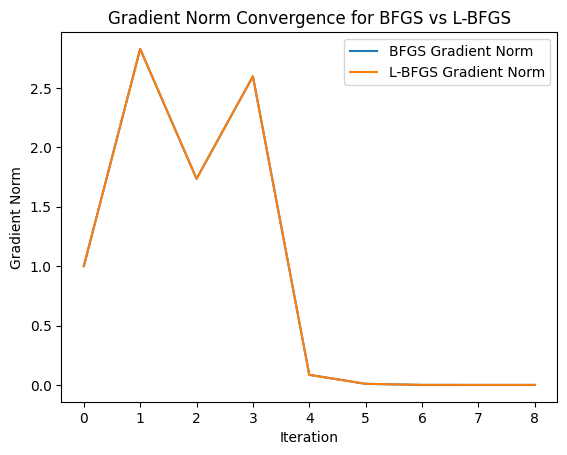

In [13]:
# Оптимизация с отслеживанием для BFGS и L-BFGS
x_opt_BFGS, values_BFGS, grad_norms_BFGS = BFGS_with_gradient_tracking(x0, gradient)
x_opt_LBFGS, values_LBFGS, grad_norms_LBFGS = L_BFGS_with_gradient_tracking(x0, gradient)

# Визуализация нормы градиента для BFGS и L-BFGS
plt.plot(grad_norms_BFGS, label="BFGS Gradient Norm")
plt.plot(grad_norms_LBFGS, label="L-BFGS Gradient Norm")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Convergence for BFGS vs L-BFGS")
plt.legend()
plt.show()


In [14]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


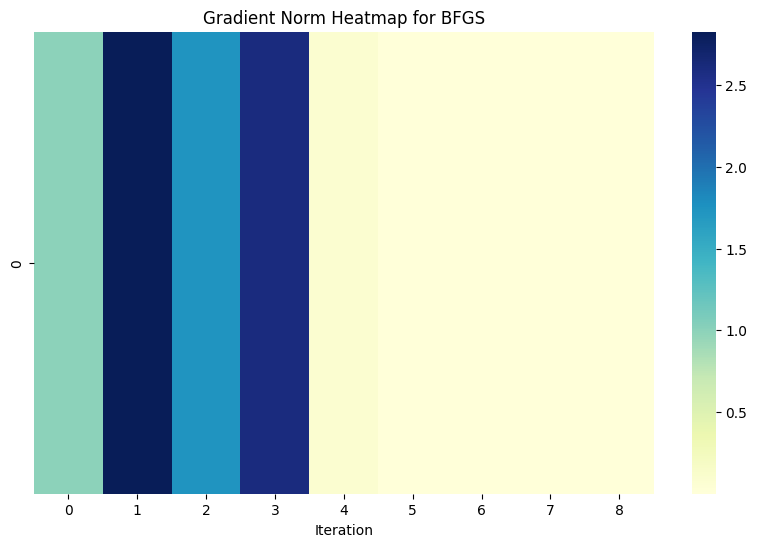

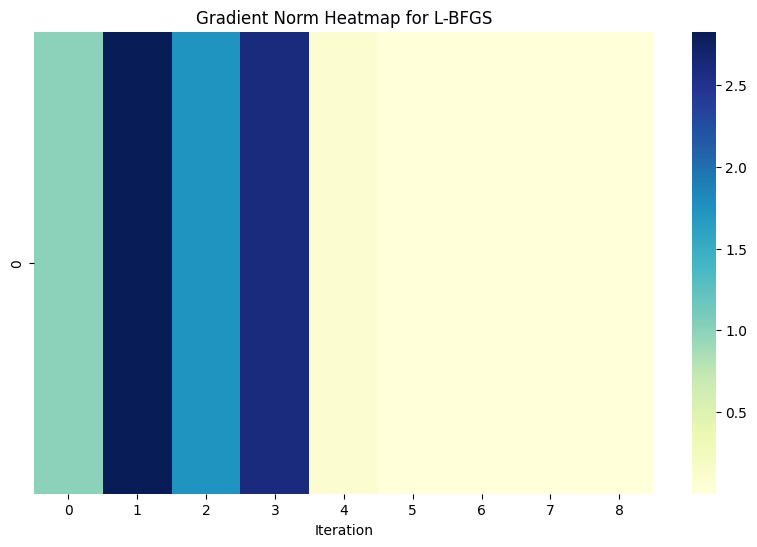

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Функция для создания heatmap
def create_heatmap(data, method_name):
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array([data]), cmap="YlGnBu", annot=False, cbar=True)
    plt.title(f"Gradient Norm Heatmap for {method_name}")
    plt.xlabel("Iteration")
    plt.show()

# Генерация данных
x_opt_BFGS, values_BFGS, grad_norms_BFGS = BFGS_with_gradient_tracking(x0, gradient)
x_opt_LBFGS, values_LBFGS, grad_norms_LBFGS = L_BFGS_with_gradient_tracking(x0, gradient)

# Визуализация Heatmap для BFGS и L-BFGS
create_heatmap(grad_norms_BFGS, "BFGS")
create_heatmap(grad_norms_LBFGS, "L-BFGS")


При обратном методе нахождения градиента

In [16]:
# Метод конечных разностей (обратный)
def finite_difference_gradient_backward(x, h=1e-5):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_h = np.copy(x)
        x_h[i] -= h  # Изменение только в отрицательную сторону для обратной разности
        grad[i] = (objective_function(x) - objective_function(x_h)) / h
    return grad


In [17]:
# Оптимизация BFGS с обратными конечными разностями для градиента
x_opt_BFGS_backward, values_BFGS_backward, grad_norms_BFGS_backward = BFGS_with_gradient_tracking(x0, finite_difference_gradient_backward)

# Оптимизация L-BFGS с обратными конечными разностями для градиента
x_opt_LBFGS_backward, values_LBFGS_backward, grad_norms_LBFGS_backward = L_BFGS_with_gradient_tracking(x0, finite_difference_gradient_backward)


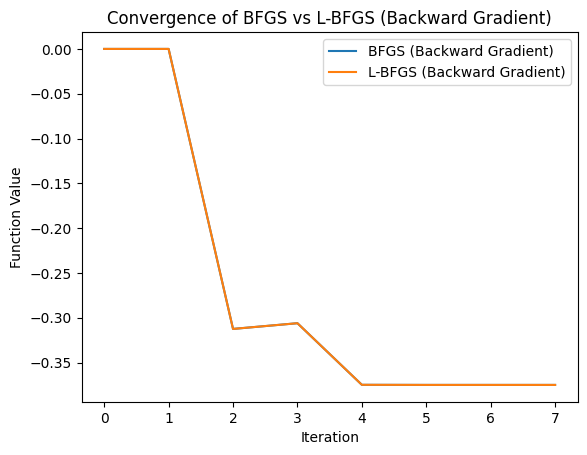

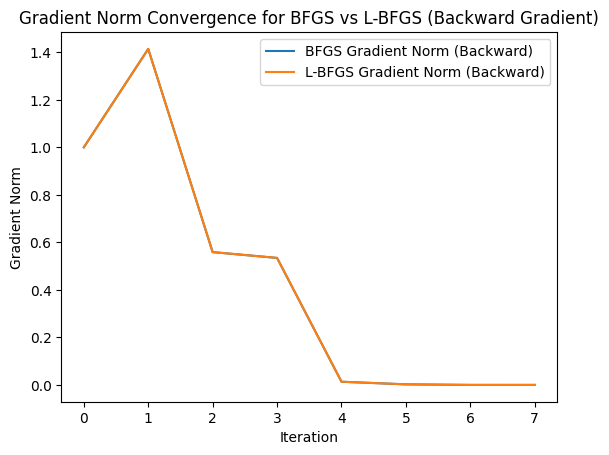

In [18]:
# Визуализация функции с использованием обратного метода для градиента
plt.plot(values_BFGS_backward, label="BFGS (Backward Gradient)")
plt.plot(values_LBFGS_backward, label="L-BFGS (Backward Gradient)")
plt.xlabel("Iteration")
plt.ylabel("Function Value")
plt.title("Convergence of BFGS vs L-BFGS (Backward Gradient)")
plt.legend()
plt.show()

# Визуализация нормы градиента для BFGS и L-BFGS (обратные конечные разности)
plt.plot(grad_norms_BFGS_backward, label="BFGS Gradient Norm (Backward)")
plt.plot(grad_norms_LBFGS_backward, label="L-BFGS Gradient Norm (Backward)")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Convergence for BFGS vs L-BFGS (Backward Gradient)")
plt.legend()
plt.show()
